In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *


In [2]:
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
# import train_test_split
from sklearn.model_selection import train_test_split

In [3]:
import pickle

In [4]:
cd ..


/home/rd804/m-anode


In [5]:
np.isnan(torch.tensor(2).item())


False

In [6]:
#os.environ["CUDA_VISIBLE_DEVICES"]='2'

CUDA = True
device = torch.device("cuda:3" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}


In [7]:
# define nan


In [8]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3

with open('data/true_w.pkl', 'rb') as f:
    true_w = pickle.load(f)

with open('data/background.pkl', 'rb') as f:
    background = pickle.load(f)


# fit train data
best_parameters = {}
run = 0

sig_train = 1

best_parameters[str(sig_train)] = {}

# Load train data
x_train = data[str(sig_train)]['train']['data']

_X_train = np.concatenate((x_train, background), axis=0)
_y_train = np.concatenate((np.ones(len(x_train)), np.zeros(len(background))), axis=0)


_X_train, _y_train  = shuffle(_X_train, _y_train, random_state=10)


X_train , X_val = train_test_split(_X_train, test_size=0.5, random_state=22)
y_train , y_val = train_test_split(_y_train, test_size=0.5, random_state=22)



In [9]:
len(y_train[y_train==0])

49863

In [10]:
x_test = data['10']['val']['data']
label_test = data['10']['val']['label']

testtensor = torch.from_numpy(x_test.reshape(-1,1)).float()


In [11]:
# define X_train y_train to be used for loading to dataloader

batch_size = 1024

X_train = torch.from_numpy(X_train.reshape(-1,1)).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()

X_val = torch.from_numpy(X_val.reshape(-1,1)).float()
y_val = torch.from_numpy(y_val.reshape(-1,1)).float()

traindataset = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)

valdataset = torch.utils.data.TensorDataset(X_val, y_val)
valloader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size*5, shuffle=False)



In [12]:
pwd

'/home/rd804/m-anode'

In [13]:
model_S=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0, device=device)
model_B=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0, device=device)

#w = torch.tensor(0.0, requires_grad=True, device=device)

#optimizer = torch.optim.Adam(list(model_S.parameters()) + list(model_B.parameters()) + [w], lr=1e-3)

In [14]:

valloss = np.load('results/nflows_gaussian_mixture_1/CR/try_0/valloss_list_background.npy')

index = np.argmin(valloss).flatten()[0]

model_B.load_state_dict(torch.load(f'results/nflows_gaussian_mixture_1/CR/try_0/model_CR_{index}.pt'))


optimizer = torch.optim.Adam(list(model_S.parameters()), lr=1e-3)

In [15]:
y_train.shape

torch.Size([150223, 1])

In [16]:
traindataset = torch.utils.data.TensorDataset(X_train, y_train )
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)


initialize w:  0.01
Computing w...
epoch:  0
before training w:  0.00995851
epoch: 0, train_loss: 256192.236
w:  0.009958510287106037


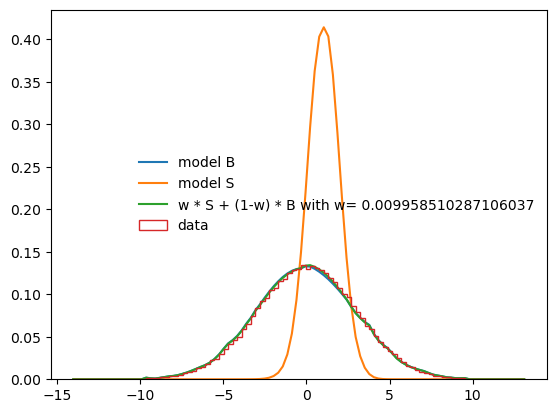

Computing w...
epoch:  1
before training w:  0.010075842
epoch: 1, train_loss: 256274.083
w:  0.010075842030346394


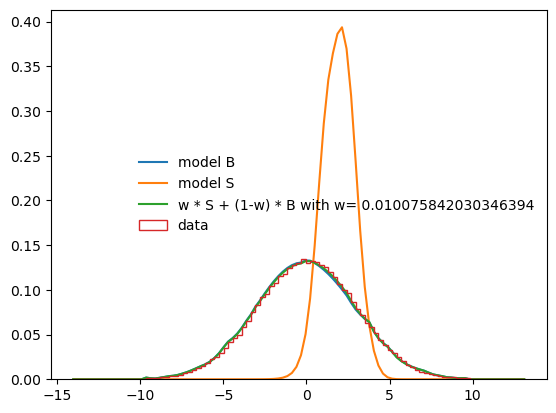

Computing w...
epoch:  2
before training w:  0.010265773
epoch: 2, train_loss: 256267.587
w:  0.01026577316224575


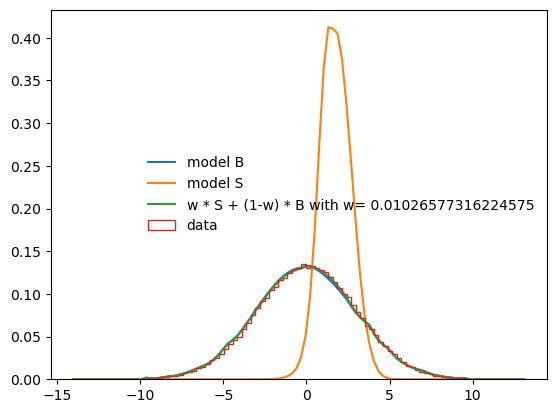

Computing w...
epoch:  3
before training w:  0.0104463855
epoch: 3, train_loss: 256156.801
w:  0.010446385480463505


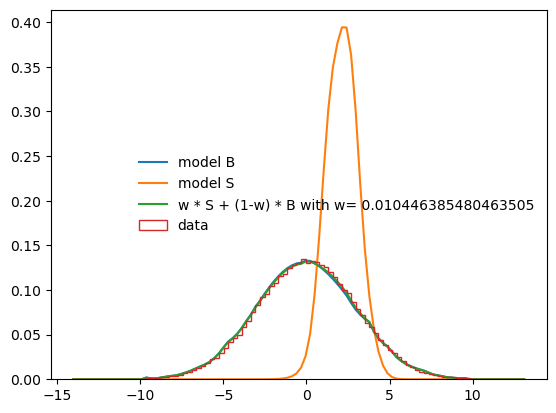

Computing w...
epoch:  4
before training w:  0.010628563
epoch: 4, train_loss: 256303.552
w:  0.010628563351929188


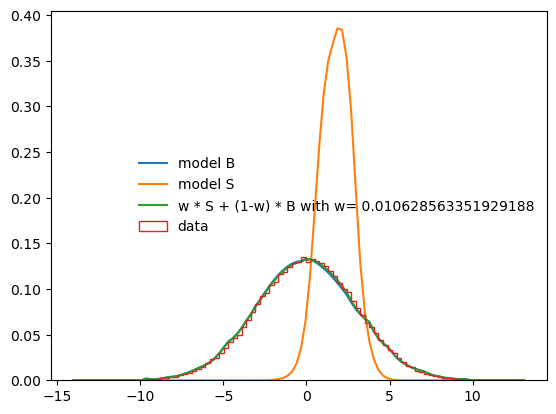

Computing w...
epoch:  5
before training w:  0.010818491
epoch: 5, train_loss: 256271.482
w:  0.010818490758538246


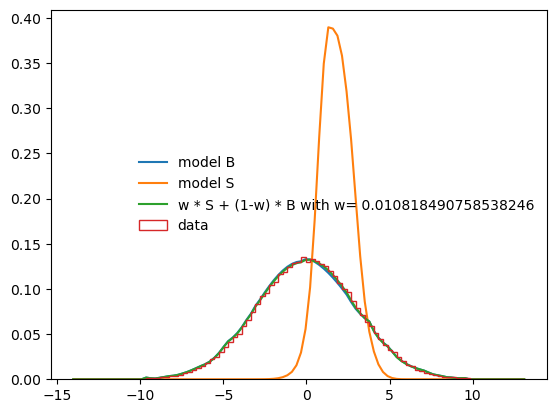

Computing w...
epoch:  6
before training w:  0.011008239
epoch: 6, train_loss: 256248.426
w:  0.011008239351212978


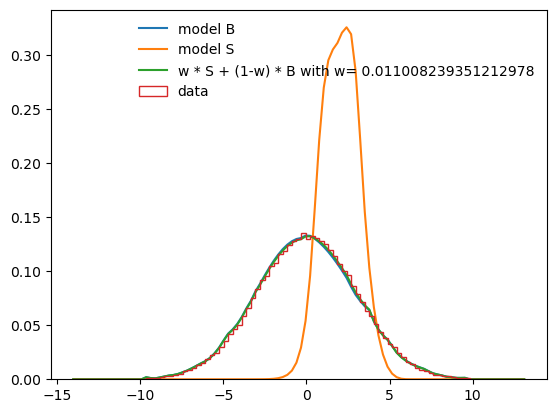

Computing w...
epoch:  7
before training w:  0.011209646
epoch: 7, train_loss: 256281.300
w:  0.011209646239876747


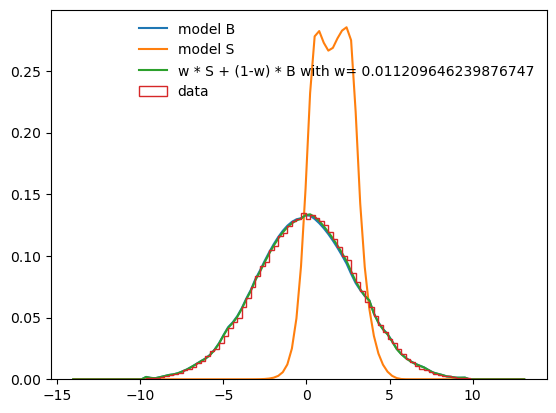

Computing w...
epoch:  8
before training w:  0.011412067
epoch: 8, train_loss: 256254.677
w:  0.011412067338824272


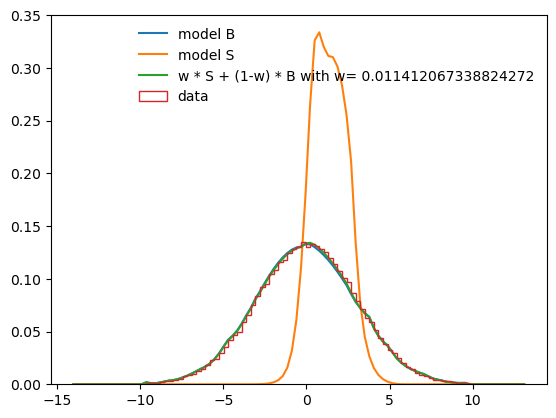

Computing w...
epoch:  9
before training w:  0.011588962
epoch: 9, train_loss: 256193.415
w:  0.011588961817324162


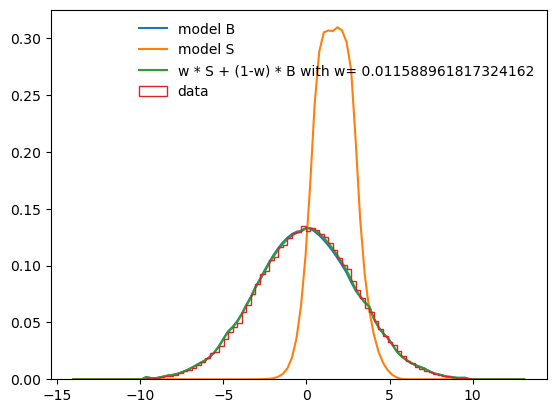

In [17]:
valloss = []
trainloss = []

w = 0.01

print('initialize w: ', w)

for epoch in range(10):

   print('Computing w...')
   print('epoch: ', epoch)
    
   model_B.eval()
   model_S.eval()
   with torch.no_grad():
      log_p_B = model_B.log_prob(X_train.to(device)).cpu().numpy()
      log_p_S = model_S.log_prob(X_train.to(device)).cpu().numpy()

      p_B = np.exp(log_p_B)
      p_S = np.exp(log_p_S)

      p_b_x = ((1-w) * p_B/((1-w) * p_B + w * p_S))

      p_s_x = 1 - p_b_x
      p_s_x = np.nan_to_num(p_s_x).reshape(-1,1)
      
      p_s_x_1 = p_s_x[y_train.flatten()==1]
      w = p_s_x_1.mean()


 
    #  valdataset = torch.utils.data.TensorDataset(X_val, y_val, p_s_x)
    #  valloader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size*5, shuffle=False)




   print('before training w: ',  w)



   train_loss = m_anode_EM(model_S,model_B,w,optimizer,trainloader,noise_data=0,noise_context=0, device=device, mode='train',
                           mode_background='fixed', data_loss_expr='expectation_likelihood',
                        clip_grad=False)
  # val_loss = m_anode_EM(model_S,model_B,w,optimizer,valloader,noise_data=0,noise_context=0, device=device, mode='val',
   #                  data_loss_expr='expectation_likelihood',
    #                       mode_background='fixed')

   model_B.eval()
   model_S.eval()
   bins = np.linspace(min(X_train), max(X_train), 100).flatten()


   w_ = w.mean().item()


   Background = model_B.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()
   Signal = model_S.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()

   Data = w_ * Signal + (1-w_) * Background

   trainloss.append(train_loss)

   print('epoch: %d, train_loss: %.3f' % (epoch, train_loss))
   print('w: ' , w.item())

   plt.plot(bins, Background, label='model B')
   plt.plot(bins, Signal, label='model S')
   plt.plot(bins, Data, label=f'w * S + (1-w) * B with w= {w_}')
   plt.hist(X_train[y_train==1], bins=bins, label='data', density=True, histtype='step')
   plt.legend(frameon=False)
   plt.show()



In [18]:
model_B.eval()
model_S.eval()

param_s_sum = 0
param_b_sum = 0

for (param_S, param_B) in zip(model_S.parameters(), model_B.parameters()):
    param_S.requires_grad = False
    param_B.requires_grad = False

    param_s_sum += param_S.sum()
    param_b_sum += param_B.sum()

print(param_s_sum, param_b_sum)



tensor(38.5000, device='cuda:3') tensor(136.0893, device='cuda:3')


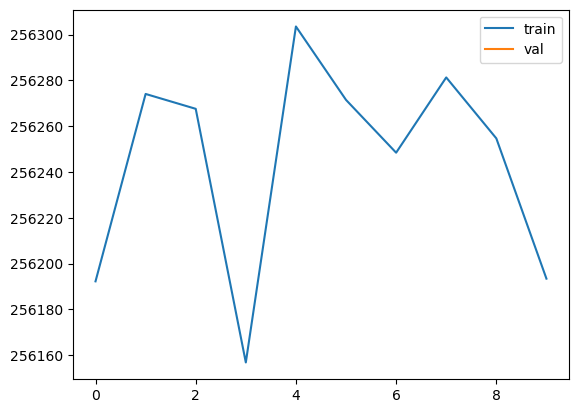

In [19]:
plt.plot(trainloss, label='train')
plt.plot(valloss, label='val')
plt.legend()
plt.show()

In [20]:
w.mean()

0.011588962

In [21]:
sig_train

1

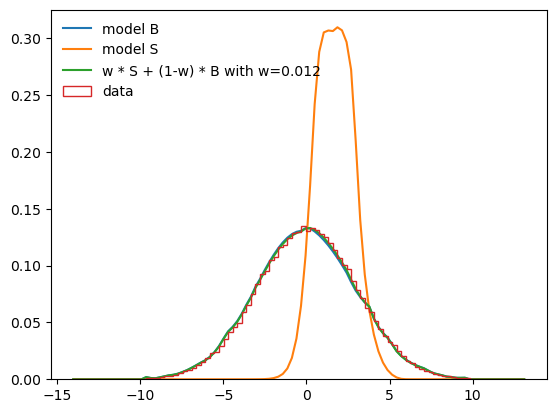

In [22]:
model_B.eval()
model_S.eval()
bins = np.linspace(min(X_train), max(X_train), 100).flatten()

#valloss = np.load('results/nflows_gaussian_mixture_1/m_anode_hyperparam_test/true_likelihood_mode_background_freeze/valloss.npy')
#index = np.argmin(valloss).flatten()[0]
#index = 99
#print(index)

#model_S.load_state_dict(torch.load(f'results/nflows_gaussian_mixture_1/m_anode_hyperparam_test/true_likelihood_mode_background_freeze/model_S_{index}.pt'))
#w_ = np.load(f'results/nflows_gaussian_mixture_1/m_anode_hyperparam_test/true_likelihood_mode_background_freeze/w_{index}.npy').item()
#w_ = 0.1
w_ = w.mean().item()
#w_ = torch.sigmoid(w).item()
#w_ = true_w[str(sig_train)][0]

Background = model_B.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()
Signal = model_S.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()

Data = w_ * Signal + (1-w_) * Background

plt.plot(bins, Background, label='model B')
plt.plot(bins, Signal, label='model S')
plt.plot(bins, Data, label='w * S + (1-w) * B with w=%.3f' % w_)
#plt.hist(X_train[y_train==0], bins=bins, label='back' , density=True, histtype='step')
plt.hist(X_train[y_train==1], bins=bins, label='data', density=True, histtype='step')

#plt.hist(x_test[label_test==0], bins=bins, label='back test', density=True, histtype='step')
#plt.hist(x_test[label_test==1], bins=bins, label='data test', density=True, histtype='step')
plt.legend(frameon=False)
plt.show()


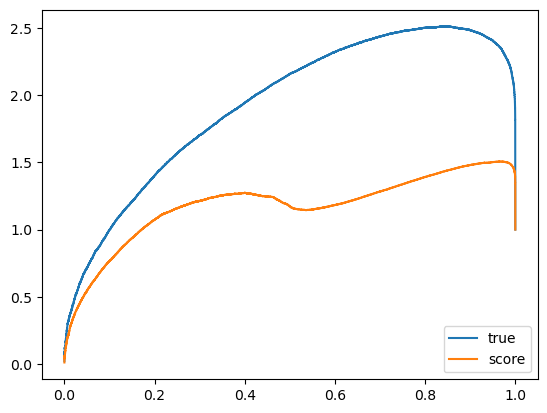

In [23]:
true_likelihoods = {}
true_likelihoods[str(sig_train)] = {}


w1 = true_w[str(sig_train)][0]
w2 = true_w[str(sig_train)][1]

true_likelihoods[str(sig_train)] = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)


score_likelihoods = {}
score_likelihoods[str(sig_train)] = {}


model_S.eval()
model_B.eval()
with torch.no_grad():
    log_S = model_S.log_prob(testtensor.to(device)).cpu().detach().numpy()
    log_B = model_B.log_prob(testtensor.to(device)).cpu().detach().numpy()

   # data  = w_ * np.exp(log_S) + (1-w_) * np.exp(log_B)
   # back = np.exp(log_B)



    likelihood_2 = log_S - log_B

    likelihood_2 = np.nan_to_num(likelihood_2, nan=0, posinf=0, neginf=0)

  #  score_likelihoods[str(sig_train)] = likelihood_
    

sic_true , tpr_true , auc_true = SIC(label_test, true_likelihoods[str(sig_train)])
sic_score , tpr_score , auc_score_2 = SIC(label_test, likelihood_2)

figure = plt.figure()

plt.plot(tpr_true, sic_true, label='true')
plt.plot(tpr_score, sic_score, label='score')

#plt.plot(tpr_score_2, sic_score_2, label='score epoch 99')


plt.legend(loc='lower right')
plt.show()


In [24]:
print(auc_true, auc_score, auc_score_2)

NameError: name 'auc_score' is not defined

In [ ]:
true_w[str(sig_train)][0]

0.021870965217731523

In [ ]:
X_train

tensor([[ 1.6612],
        [-1.2352],
        [ 0.6883],
        ...,
        [-0.7990],
        [-3.0925],
        [ 0.6226]])

In [ ]:
model_B.eval()
model_S.eval()

model_B.to(device)
model_S.to(device)

with torch.no_grad():
    log_S = model_S.log_prob(X_train.to(device)).cpu().numpy()
    log_B = model_B.log_prob(X_train.to(device)).cpu().numpy()

exp_S = np.exp(log_S)
exp_B = np.exp(log_B)


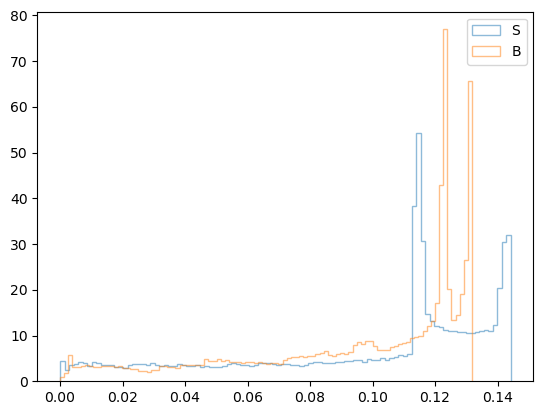

In [ ]:
plt.hist(exp_S, bins=100, alpha=0.5, label='S', density=True, histtype='step')
plt.hist(exp_B, bins=100, alpha=0.5, label='B', density=True, histtype='step')
plt.legend()
plt.show()

In [ ]:
X_train[(exp_B==0) & (exp_S==0)]

tensor([[-14.5105]])

In [ ]:
np.argwhere((exp_B==0) & (exp_S==0))

array([[120407]])

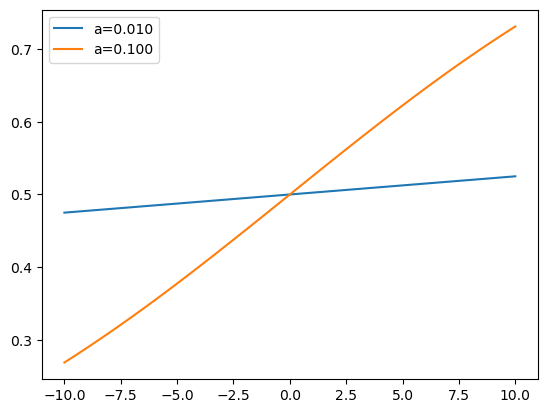

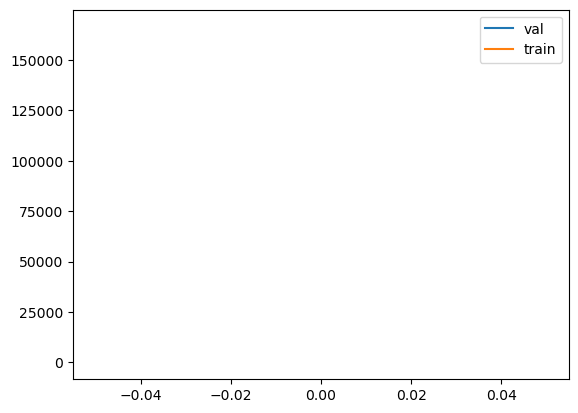

NameError: name 'valloss_list' is not defined

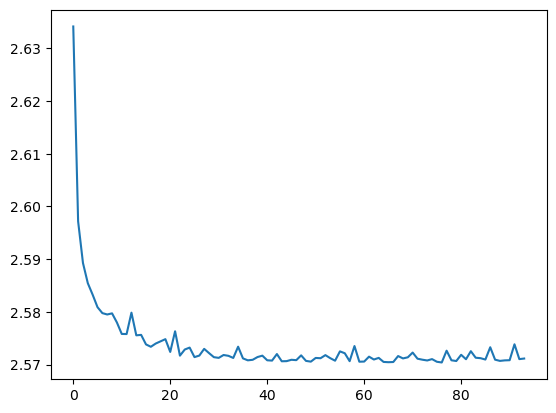

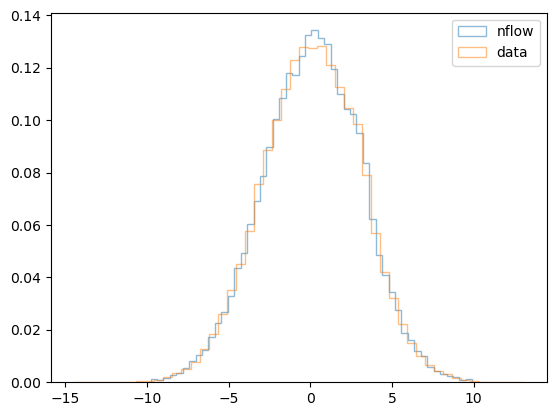

min epoch:  76



 Epoch: 0

 Epoch: 1

 Epoch: 2

 Epoch: 3

 Epoch: 4

 Epoch: 5

 Epoch: 6

 Epoch: 7

 Epoch: 8

 Epoch: 9

 Epoch: 10

 Epoch: 11

 Epoch: 12

 Epoch: 13

 Epoch: 14

 Epoch: 15

 Epoch: 16

 Epoch: 17

 Epoch: 18

 Epoch: 19

 Epoch: 20

 Epoch: 21

 Epoch: 22

 Epoch: 23

 Epoch: 24

 Epoch: 25

 Epoch: 26

 Epoch: 27

 Epoch: 28

 Epoch: 29

 Epoch: 30

 Epoch: 31

 Epoch: 32

 Epoch: 33

 Epoch: 34

 Epoch: 35

 Epoch: 36

 Epoch: 37

 Epoch: 38

 Epoch: 39

 Epoch: 40

 Epoch: 41

 Epoch: 42

 Epoch: 43

 Epoch: 44

 Epoch: 45

 Epoch: 46

 Epoch: 47

 Epoch: 48

 Epoch: 49

 Epoch: 50

 Epoch: 51

 Epoch: 52

 Epoch: 53

 Epoch: 54

 Epoch: 55

 Epoch: 56

 Epoch: 57

 Epoch: 58

 Epoch: 59

 Epoch: 60

 Epoch: 61

 Epoch: 62

 Epoch: 63

 Epoch: 64

 Epoch: 65

 Epoch: 66

 Epoch: 67

 Epoch: 68

 Epoch: 69

 Epoch: 70

 Epoch: 71

 Epoch: 72

 Epoch: 73

 Epoch: 74

 Epoch: 75

 Epoch: 76

 Epoch: 77

 Epoch: 78

 Epoch: 79

 Epoch: 80

 Epoch: 81

 Epoch: 82

 Epoch: 83

 

min epoch:  98


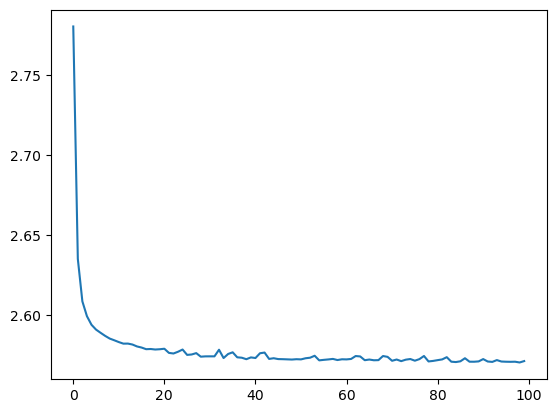

<All keys matched successfully>

<All keys matched successfully>

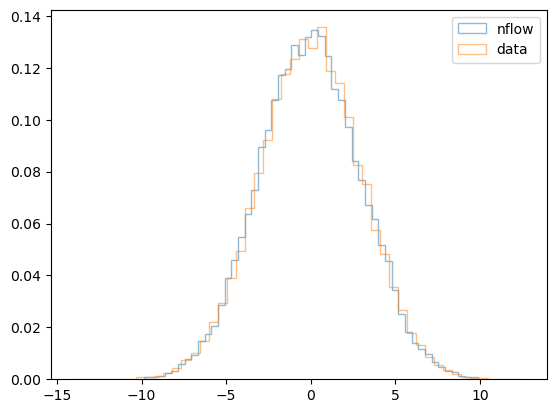

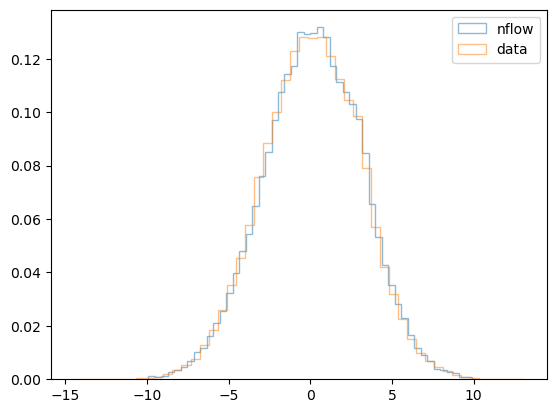

In [ ]:
label_test

array([0., 0., 0., ..., 1., 1., 1.])

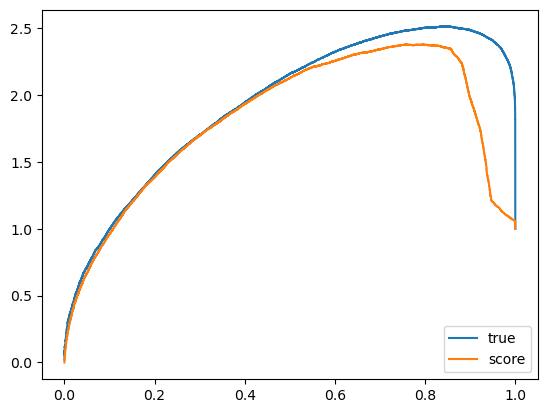